Let's get the stats that maybe everyone can agree on as a start


In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from rubin_sim.satellite_constellations import (Constellation, starlink_tles_v2,
                                                oneweb_tles,
                                                ModelObservatory,
                                                SatelliteAvoidBasisFunction)
import healpy as hp
from rubin_sim.data import get_baseline
import pandas as pd
import sqlite3
import os

In [2]:
save_file = 'streaks_all.npz'

In [3]:
# a starlink gen 2 + oneweb
tles = starlink_tles_v2() #+ oneweb_tles()
const = Constellation(tles)
print('number of satellites= ', len(tles))

number of satellites=  29988


In [33]:
# note, this was done with 3.0, so might need to dial it back to that to get this right in the future
baseline = get_baseline()
run_name = os.path.basename(baseline.replace('.db', ''))
con = sqlite3.connect(baseline)
# year 1
visits = pd.read_sql('select fieldRA, fieldDec, altitude, fivesigmadepth, observationstartmjd,rotSkyPos,visitExposureTime from observations where night < 365', con)
con.close()

In [34]:
visits

,fieldRA,fieldDec,altitude,fiveSigmaDepth,observationStartMJD,rotSkyPos,visitExposureTime
0,298.603526,-15.574752,75.329938,22.546480,60218.001806,224.242758,30.0
1,297.035243,-13.144502,72.746954,22.532127,60218.002260,231.080063,30.0
2,295.418862,-15.854174,75.089050,22.546281,60218.002715,238.282952,30.0
3,356.288005,-51.164810,43.773216,23.128326,60218.004914,129.375130,30.0
4,0.158759,-53.139864,41.748927,23.075882,60218.005362,130.108353,30.0
...,...,...,...,...,...,...,...
216115,127.418325,-9.886886,41.639855,22.575541,60582.395343,147.208171,15.0
216116,125.666648,-7.743953,41.993831,22.589142,60582.395579,149.420262,15.0
216117,127.022962,-4.908917,39.334848,22.458614,60582.395820,150.936373,15.0
216118,130.532609,-9.181433,38.874909,22.447880,60582.396063,146.931615,15.0


In [6]:
keys = ['fieldRA', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'rotSkyPos', 'visitExposureTime']
types = [float] * len(keys)

numpy_visits = np.zeros(np.size(visits["fieldRA"].values), dtype=list(zip(keys,types)))

for key in keys:
    numpy_visits[key] = visits[key].values



In [7]:
if os.path.isfile(save_file):
    data = np.load(save_file)
    streak_lengths = data['streak_lengths'].copy()
    n_streaks = data['n_streaks'].copy()
    data.close()
#else:
    #streak_lengths, n_streaks = const.check_pointings(visits["fieldRA"].values,
    #                                                     visits["fieldDec"].values,
    #                                                     visits["observationStartMJD"].values, visit_time=32.)
    #np.savez(save_file, streak_lengths=streak_lengths, n_streaks=n_streaks)

In [8]:
n_streaks

array([0, 0, 0, ..., 0, 0, 1])

In [9]:
np.shape(n_streaks)

(216120,)

In [10]:
# save so we don't have to grind that out again
#if not os.path.isfile('streaks.npz'):
#    np.savez('streaks.npz', streak_lengths=streak_lengths, n_streaks=n_streaks)

In [11]:
# not quite right because I have NEO mixed in
exptimes = numpy_visits['visitExposureTime']+0
exptime_before = np.sum(exptimes)
exptimes[np.where(n_streaks > 0)] = exptimes[np.where(n_streaks > 0)]/2.
exptime_after = np.sum(exptimes)

print('Fractional loss of total exposure=', (exptime_before-exptime_after)/exptime_before)


Fractional loss of total exposure= 0.039585378597419396


In [12]:
# what fraction of pixels are lost to streaks with a 1 arcmin mask
# 
pixscale = 0.2 # arcsec/pix
tot_pix = 3.2e9 # total pixels in focal plane
mask_width = 60 # arcsec

print('fraction of pix lost', np.sum(streak_lengths/pixscale*3600 * mask_width /pixscale)/(tot_pix*np.size(streak_lengths)))
# fraction of images with a streak
print('fraction of streaked images= ', np.where(n_streaks > 0)[0].size/np.size(n_streaks))
print('mean streak length', np.mean(streak_lengths)*60, ' (arcmin)') # to arcmin

fraction of pix lost 0.00043041973301933905
fraction of streaked images=  0.08392096983157506
mean streak length 15.303812729576498  (arcmin)


In [13]:
non_neo = np.where(numpy_visits["visitExposureTime"] > 20)[0]
print('number of non-NEO visits = %i' % non_neo.size)
print('fraction of non-neo streaked images= ', np.where(n_streaks[non_neo] > 0)[0].size/np.size(n_streaks[non_neo]))

print('fraction of pix lost non-NEO', np.sum(streak_lengths[non_neo]/pixscale*3600 * mask_width /pixscale)/(tot_pix*np.size(streak_lengths[non_neo])))
print('mean streak length non-NEO', np.mean(streak_lengths[non_neo])*60, ' (arcmin)') # to arcmin


number of non-NEO visits = 210679
fraction of non-neo streaked images=  0.07429786547306566
fraction of pix lost non-NEO 0.000391380638286256
mean streak length non-NEO 13.915756027955771  (arcmin)


In [14]:
neo = np.where(numpy_visits["visitExposureTime"] <= 20)[0]
print('number of NEO visits=%i' % neo.size)
print('fraction of neo streaked images= ', np.where(n_streaks[neo] > 0)[0].size/np.size(n_streaks[neo]))
print('fraction of pix lost neo', np.sum(streak_lengths[neo]/pixscale*3600 * mask_width /pixscale)/(tot_pix*np.size(streak_lengths[neo])))
print('mean streak length NEO', np.mean(streak_lengths[neo])*60, ' (arcmin)') # to arcmin


number of NEO visits=5441
fraction of neo streaked images=  0.45653372541812165
fraction of pix lost neo 0.001942038450032973
mean streak length NEO 69.05025600117237  (arcmin)


Text(0.5, 1.0, 'baseline_v3.0_10yrs')

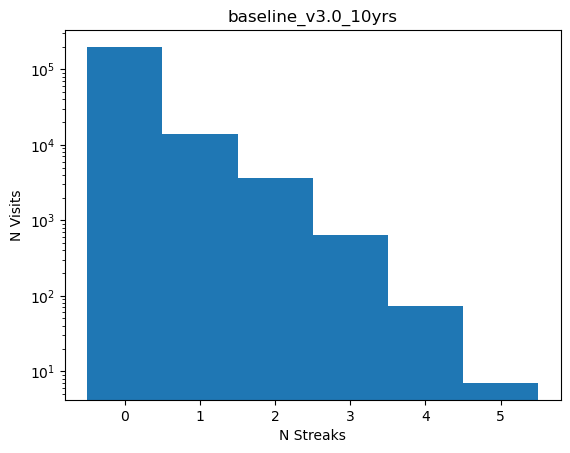

In [25]:
bins = np.arange(0,7, 1) - 0.5
_ack = plt.hist(n_streaks, bins=bins)
plt.yscale('log')
plt.xlabel('N Streaks')
plt.ylabel('N Visits')
plt.title(run_name)

In [30]:
# OK, streak length is in degrees
ack = []
for sl in np.unique(n_streaks):
    good = np.where(n_streaks == sl)[0]
    ack.append(streak_lengths[good].mean())
    print(sl, streak_lengths[good].mean(), streak_lengths[good].max())

0 0.0 0.0
1 2.3710698721987056 3.499631849339453
2 4.725700740072628 6.993171083264245
3 7.157197399536305 10.460161917554249
4 9.550594242297768 13.596108037678052
5 11.3575114274 14.910435876186583


Text(0, 0.5, 'Mean Streak Length (deg)')

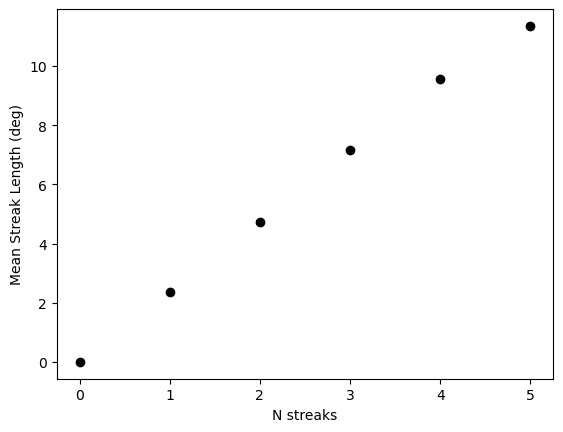

In [32]:
plt.plot(np.unique(n_streaks), ack, 'ko')
plt.xlabel('N streaks')
plt.ylabel('Mean Streak Length (deg)')

In [42]:
good = np.where(visits['altitude'] < 30)[0]
print(np.mean(n_streaks[good]), np.mean(streak_lengths[good]*60))

0.274066091954023 31.31053281608345


In [43]:
good = np.where(visits['altitude'] > 30)[0]
print(np.mean(n_streaks[good]), np.mean(streak_lengths[good]*60))

0.10545805677429032 15.09492764351116


In [45]:
np.mean(streak_lengths)*60

15.303812729576498